## Qual é o desafio?
Nessa competição, nós temos que detectar a probabilidade de transações online serem fraudulentas, usando técnicas de aprendizado de máquina. 

### Sobre os dados
Primeiro, importamos as bibliotecas necessárias.

In [ ]:
import os
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer

import joblib
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Depois baixamos os 4 arquivos de dados do desafio.

In [ ]:
train_id = pd.read_csv('/content/drive/MyDrive/p2_miceli/train_identity.csv')
train_transaction = pd.read_csv('/content/drive/MyDrive/p2_miceli/train_transaction.csv')
test_id = pd.read_csv('/content/drive/MyDrive/p2_miceli/test_identity.csv')
test_transaction =  pd.read_csv('/content/drive/MyDrive/p2_miceli/test_transaction.csv')

In [ ]:
correlation = train_transaction.corr()

Aqui foi feita a checagem do tamanho dos arquivos:

In [ ]:
trainID_GB = (train_id.memory_usage(deep = True).sum()/1024**3)
trainTR_GB = (train_transaction.memory_usage(deep = True).sum()/1024**3)
testID_GB = (test_id.memory_usage(deep = True).sum()/1024**3)
testTR_GB = (test_transaction.memory_usage(deep = True).sum()/1024**3)

print(f'The train_id dataframe is taking up about {trainID_GB:.2f} GB of memory storage')
print(f'The train_transaction dataframe is taking up about {trainTR_GB:.2f} GB of memory storage')
print(f'The test_id dataframe is taking up about {testID_GB:.2f} GB of memory storage')
print(f'The test_transaction dataframe is taking up about {testTR_GB:.2f} GB of memory storage')

The train_id dataframe is taking up about 0.15 GB of memory storage
The train_transaction dataframe is taking up about 2.05 GB of memory storage
The test_id dataframe is taking up about 0.15 GB of memory storage
The test_transaction dataframe is taking up about 1.77 GB of memory storage


E, depois, fizemos a checagem do numero de linhas e colunas:

In [ ]:
print(f'Size of train_id - rows: {train_id.shape[0]}, columns: {train_id.shape[1]}')
print(f'Size of train_transaction - rows:{train_transaction.shape[0]}, columns: {train_transaction.shape[1]}')
print(f'Size of test_id - rows: {test_id.shape[0]}, columns: {test_id.shape[1]}')
print(f'Size of test_transaction - rows:{test_transaction.shape[0]}, columns: {test_transaction.shape[1]}')

Size of train_id - rows: 144233, columns: 41
Size of train_transaction - rows:590540, columns: 394
Size of test_id - rows: 141907, columns: 41
Size of test_transaction - rows:506691, columns: 393


Descrição do banco de dados indentity: 
TransactionID — foreign key: é a chave de acesso, o identificador(id) da transação.

Para o conjunto de dados da transação id_01-id_38 — Características que não são identificadas: sobre à identidade dos titulares do cartão. DeviceType — Tipo de dispositivo usado para fazer a transação. DeviceInfo — Informações sobre as características do dispositivo.

In [ ]:
pd.pandas.set_option('display.max_columns', None)
train_id.head()


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


Descrição do banco de dados indentity: TransactionID — foreign key ( A foreign key is a column or columns of data in one table that refers to the unique data values -- often the primary key data -- in another table. Foreign keys link together two or more tables in a relational database) para o conjunto de dados da transação id_01-id_38 — Características que não são identificadas: sobre à identidade dos titulares do cartão. DeviceType — Tipo de dispositivo usado para fazer a transação. DeviceInfo — Informações sobre as características do dispositivo.

In [ ]:
pd.pandas.set_option('display.max_columns', None)
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Ambas as tabelas tem a coluna TransactionID.

Descrição dos dados: TransactionID — ID da transação e é a foreign key e no identity database. isFraud — 0 ou 1 significando se uma transação é fraudulenta ou não. TransactionDT — (timedelta) diferença de uma determinada data e hora de referência (não um timestamp real) TransactionAMT — Valor do pagamento da transação em USD. ProductCD — Código do produto. card1 — card6 — Informações do cartão de pagamento, como tipo de cartão, categoria do cartão, banco emissor, país, etc. addr1, addr2 — Endereço dist — Distância P_emaildomain — Domínio de e-mail do comprador. R_emaildomain — Domínio de e-mail do destinatário. C1-C14 — contagem, como quantos endereços estão associados ao cartão de pagamento, etc. O significado real não da pra identificar. D1-D15 — timedelta, como dias entre transações anteriores, etc. M1-M9 — correspondência -match-, como nomes no cartão e endereço, etc. V1-V339— A Vesta(empresa que forneceu os dados) projetou recursos avançados, incluindo classificação, contagem e outras relações entre entidades.

**Aqui temos um gráfico de exposição, que mostra a distribuição do train e do test ao longo do tempo:**

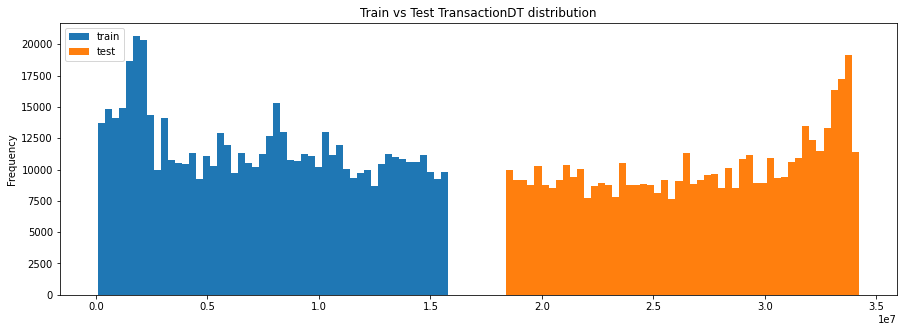

In [ ]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

Train vs Test são divisões de séries temporais
O recurso TransactionDT é um timedelta de uma determinada data e hora de referência (não um registro de data e hora real). Uma descoberta inicial sobre os dados é que o train e o test parecem ser divididos por tempo. Há um pequeno gap entre eles, snedo o conjunto de train é de um período anterior e o test é de um período posterior.

In [ ]:
# Aqui confirmamos que todas as transactions id possuem um corresespondente no banco de dados train_transaction
print(np.sum(test_transaction['TransactionID'].isin(test_id['TransactionID'].unique())))

144233
141907


Nem todas as transações têm informações de identidade correspondentes. Mas como visto acima 
24,4% dos TransactionIDs em train (144233/590540) têm um train_identity associado.
28,0% dos TransactionIDs no test (141907/506691) têm um test_identity associado.
o que é uma porcentagem relevante

Dessa forma,para torná-los mais fáceis de trabalhar, vamos juntar esses arquivos em um. Conforme mencionado anteriormente, os dois arquivos têm coluna "TransaactionID" em comum.

Aqui temos o tamanho do train_id e do train_transaction.
Depois fazemos a redução do tamanho deles.
Como existem transações com o mesmo ID em ambas as tabelas transaction e identity, foi possivel juntá-las pelo merge.

In [ ]:
print(train_id.shape, train_transaction.shape)
train = train_transaction.merge(train_id,on=['TransactionID'],how='left') 
print(f'Size of train - rows : {train.shape[0]}, columns : {train.shape[1]}')

(144233, 41) (590540, 394)
Size of train - rows : 590540, columns : 434


In [ ]:
train_GB = train.memory_usage(deep = True).sum()/1024**3 
print(f'train dataframe is using {train_GB:.2f} GB of memory storage')

train dataframe is using 2.51 GB of memory storage


Vimos acima que a criança é muito grande, tanto em relação ao número de linhas e colunas, quanto de memória ocupada. Com isso, temos que dar um jeito de reduzir isso. Primeiro, como vamos usar só o data frame mesclado daqui pra frente, não vamos mais precisar dos dataframes train_id e train_transaction, então bora excluir eles pra liberar espaço:

In [ ]:
del train_id
del train_transaction
gc.collect

<function gc.collect(generation=2)>

Além disso, pra ficar mais fácil de trabalhar,vamos usar uma função pra reduzir o tamanho do arquivo pra ele ocupar menos espaço (basicament vamos alterar os tipos de dados das colunas para que ocupem um espaço mínimo com base em seu tamanho).

In [ ]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    start_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    print(f'Initial memory usage of dataframe is {start_mem:.2f} MB/{start_mem_GB:.2f} GB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    end_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Memory usage after optimization is: {end_mem:.2f} MB/{end_mem_GB:.2f} GB')
    print(f'Decreased by {reduction:.1f}%')
    
    return df

train = reduce_mem_usage(train)

NameError: ignored

Aqui conseguimos ver o nome das colunas após o merge:

In [ ]:
','.join(train.columns.to_list())

'TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V16

Uma parte da nova tabela:

In [ ]:
pd.pandas.set_option('display.max_columns', None)
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

Percebemoms vários NaN, muitos algoritmos de aprendizado de máquina não suportam valores ausentes e, portanto, teremos que encontrar um método para resolver isso. Mas antes vamos fazer um análise exploratória no nosso banco de dados

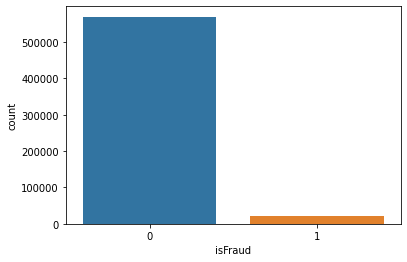

In [ ]:
sns.countplot(data=train, x='isFraud')

O gráfico acima mostra um desequilibrio, com 96,5% sendo transações válidas e 3,5% fraudulentas. Dependendo do algoritmo de aprendizado de máquina que usamos, talvez seja necessário encontrar um método para resolver o desequilíbrio.

Em seguida, veremos a distribuição de outros features no dataframe.

Vamos começar olhando para feature "card6" que informa o tipo de cartão usado na transação. Possui os valores “débito”, “crédito”, “débito ou crédito” e “cartão de débito”.

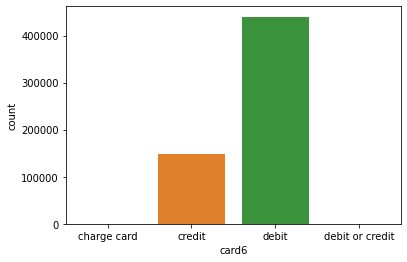

In [ ]:
sns.countplot(data=train, x='card6')

Distribuição do "Card4" (empresa de cartão de crédito):

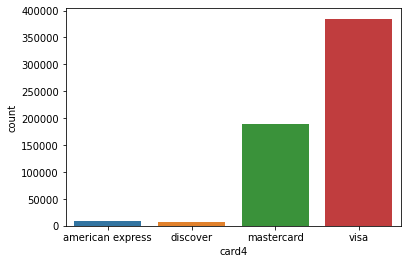

In [ ]:
sns.countplot(data=train, x='card4')

65,2% das transações em nosso conjunto de dados usaram cartões Visa, 32% usaram Mastercard, 14% usaram American Express e 11% usaram cartões Discover.

Distribuição de transações por tipo de dispositivo:

DeviceType
desktop    85165
mobile     55645
Name: TransactionDT, dtype: int64


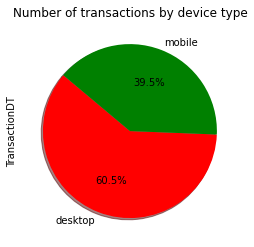

In [ ]:
device_type_df = train.groupby(by='DeviceType').TransactionDT.count()
device_type_df.plot(kind='pie',colors=['r','g'],autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Number of transactions by device type')
print(device_type_df)

Transações fraudulentas de acordo com a empresa de cartão de crédito:

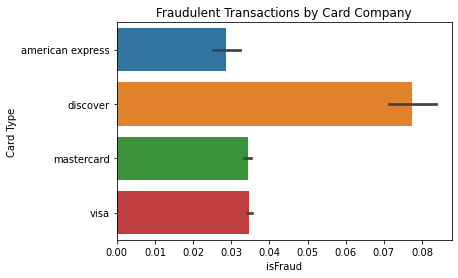

In [ ]:
sns.barplot(x ="isFraud",y="card4",data=train)
plt.xlabel('isFraud')
plt.ylabel('Card Type')
plt.title('Fraudulent Transactions by Card Company')
plt.show()



Aqui, examinamos a distribuição de transações fraudulentas por empresa de cartão de crédito. Mesmo que a discover reprensete pouca coisa em todos os conjuntos de dados, ela parece ter o maior número de transações fraudulentas

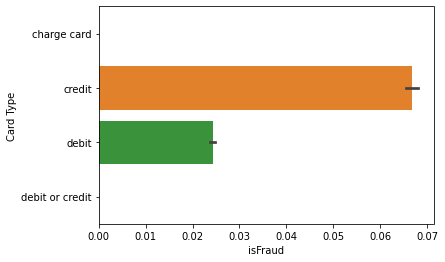

In [ ]:
sns.barplot(x ="isFraud",y="card6",data=train)
plt.xlabel('isFraud')
plt.ylabel('Card Type')
plt.show()

Transações fraudulentas por tipo de cartão

Embora as transações com cartão de crédito representem apenas cerca de 26% de todos os dados, ela possui o maior número de transações fraudulentas.

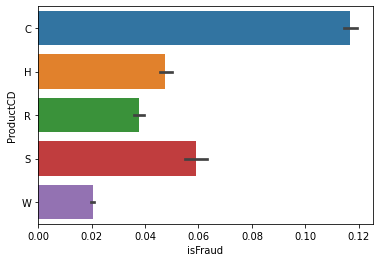

In [ ]:
#Transações fraudulentas de acordo com a coluna "ProductCD" (ou seja o tipo de produto)
sns.barplot(x ="isFraud",y="ProductCD",data=train)
plt.xlabel('isFraud')
plt.ylabel('ProductCD')
plt.show()

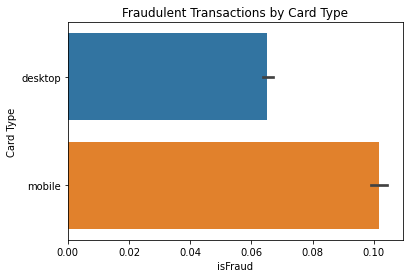

In [ ]:
sns.barplot(x ="isFraud",y="DeviceType",data=train)
plt.xlabel('isFraud')
plt.ylabel('Card Type')
plt.title('Fraudulent Transactions by Card Type')
plt.show()

Vimos anteriormente que a maioria das transações em nosso conjunto de dados foi feita em computadores desktop. No entanto, mais transações fraudulentas ocorreram em dispositivos móveis do que em computadores desktop.

In [ ]:
train['TransactionAmt'].hist( by=train['isFraud'], bins=30, figsize=(15,8))

Cobranças fraudulentas parecem ter um valor médio de transação mais alto como pode ser observado acima

# C1 - C14

In [ ]:
c_cols = [c for c in train_transaction if c[0] == 'C']
train_transaction[c_cols].head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


De acordo com esses gráficos de pares criados a partir de 500 amostras, os casos de fraude podem estar em uma relação linear ou casos de fraude e não fraude podem ser facilmente separáveis ​​linearmente em muitas combinações desses recursos....de C1 a C14

Por exemplo, o gráfico de pares de C1 e C2 parece fazer dos casos de fraude uma relação muito linear. A combinação de C14 e C5 faz parecer que os casos de fraude e não fraude são muito separáveis ​​de forma linear.


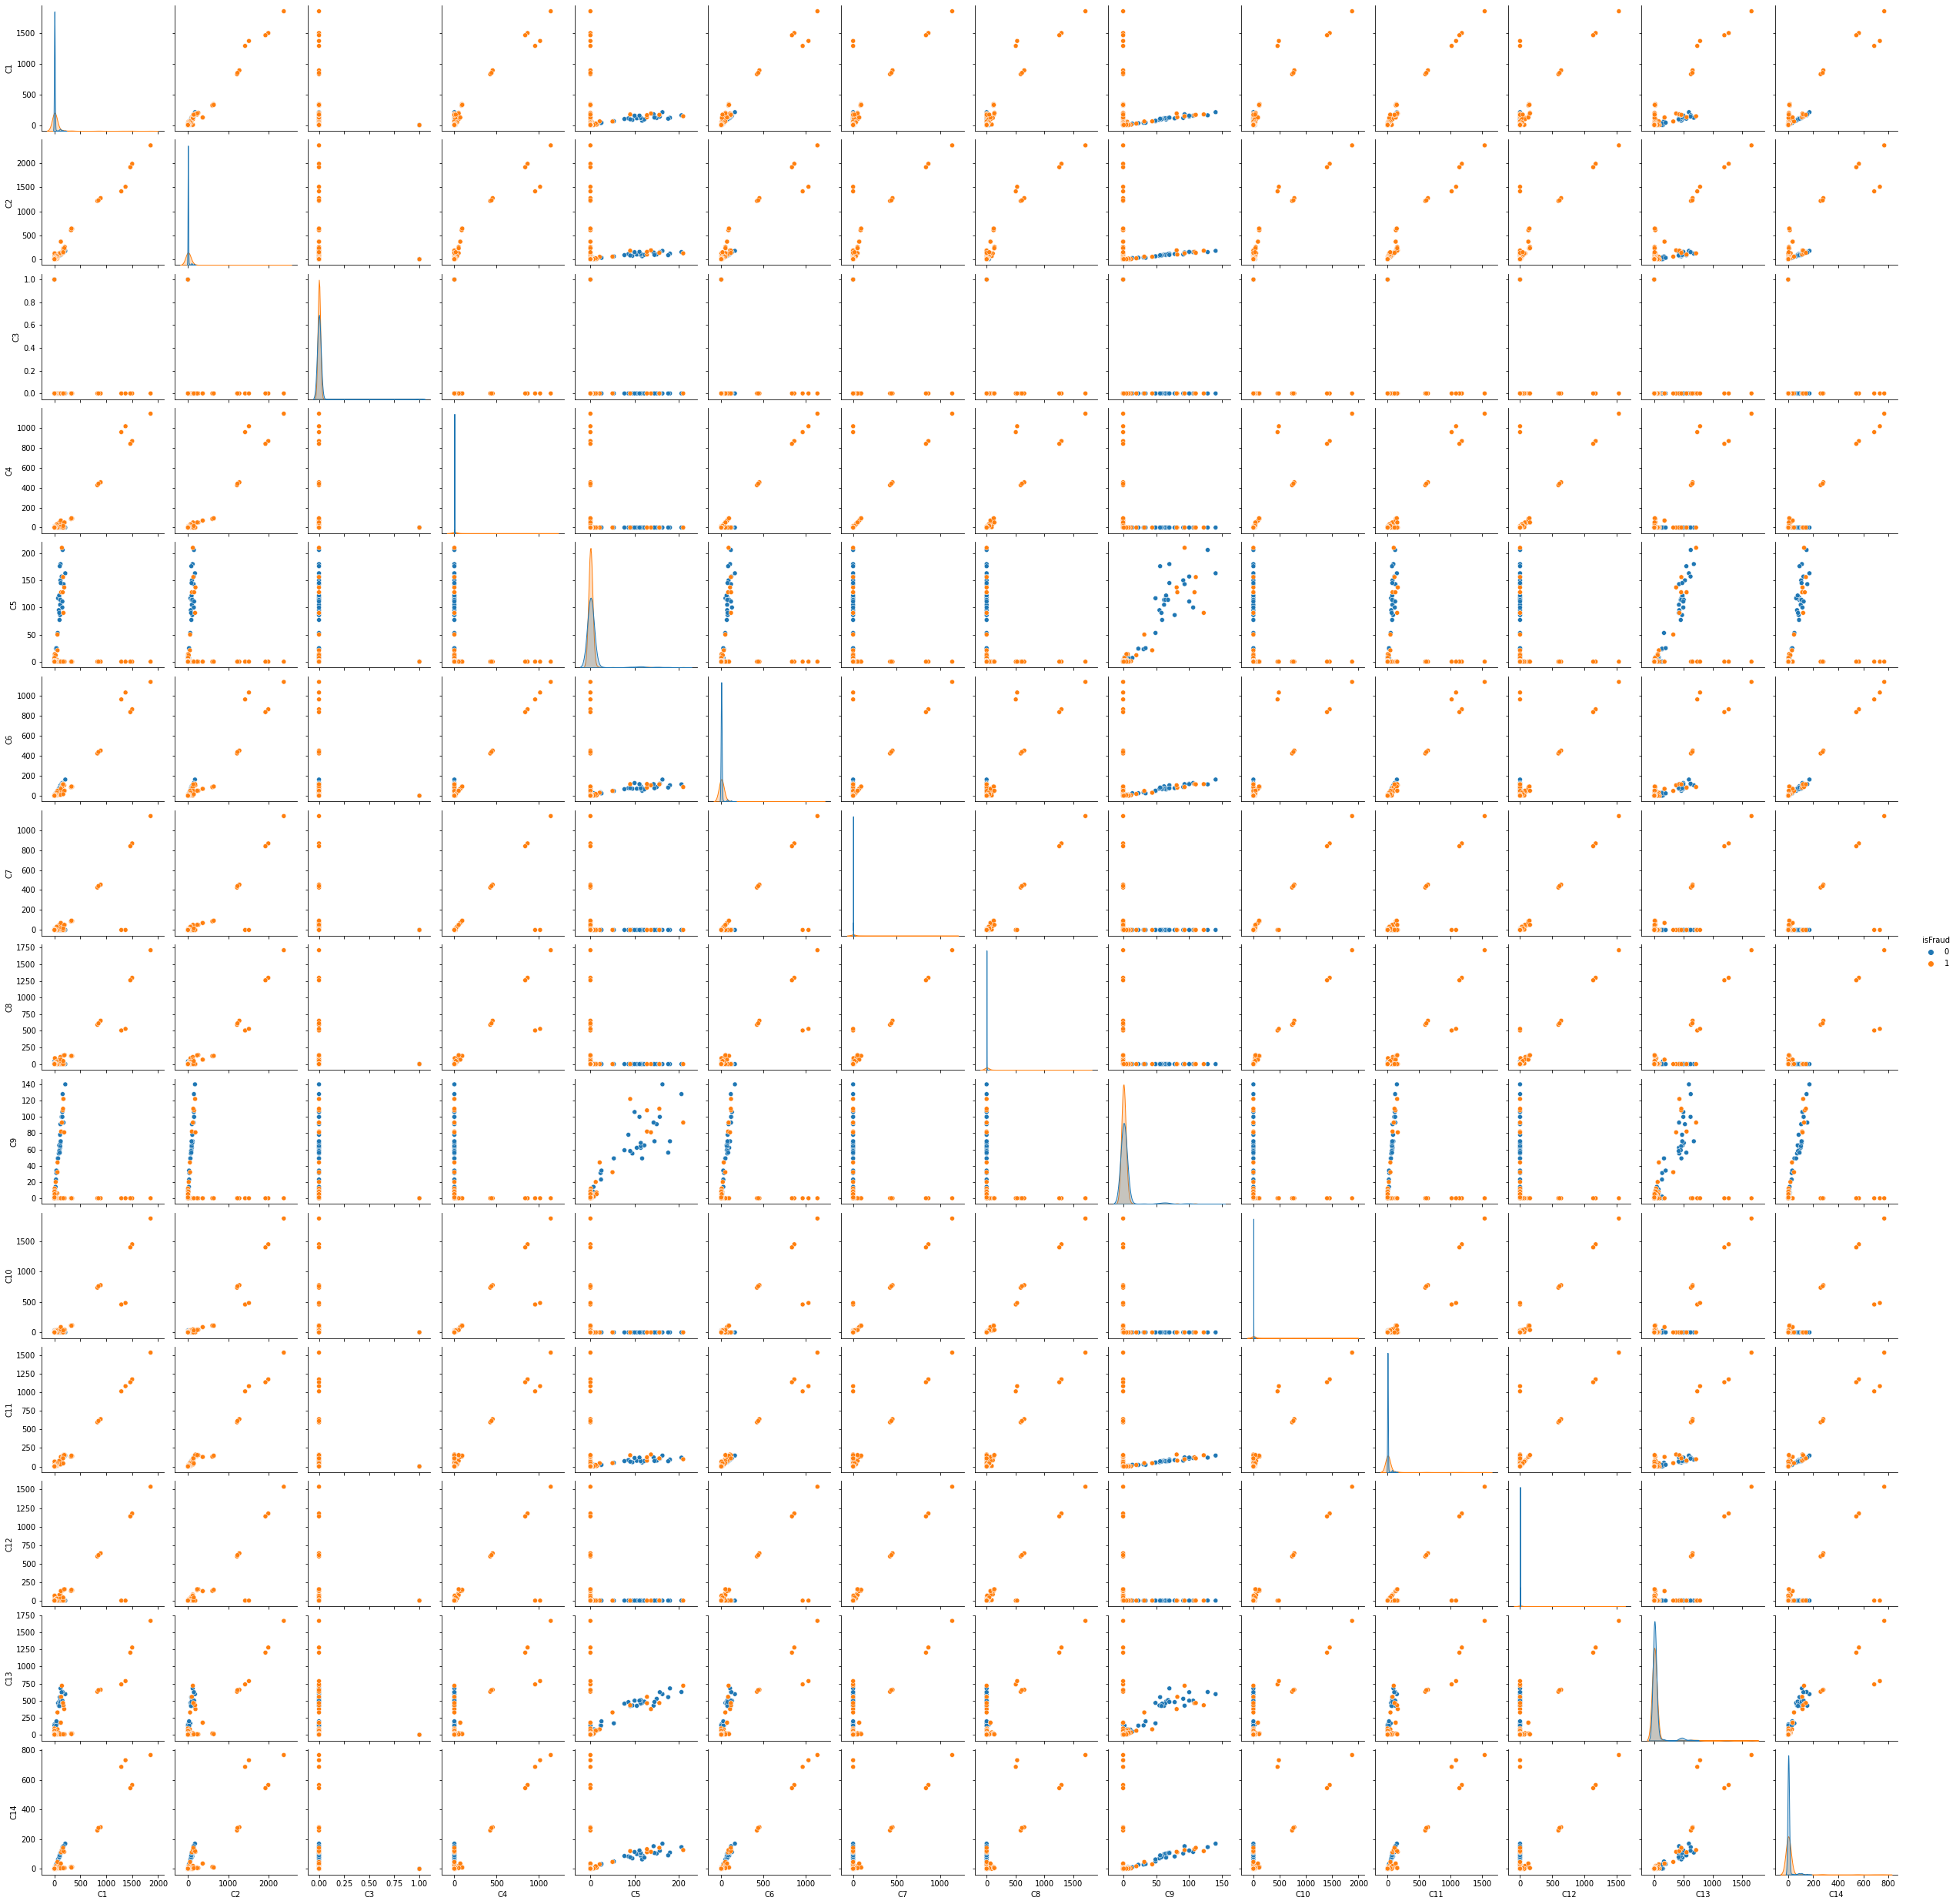

In [ ]:
# Sample 500 fraud and 500 non-fraud examples to plot
sampled_train = pd.concat([train_transaction.loc[train_transaction['isFraud'] == 0].sample(500),
          train_transaction.loc[train_transaction['isFraud'] == 1].sample(500)])

sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=c_cols)
plt.show()

# D1 - D15

In [ ]:
d_cols = [c for c in train_transaction if c[0] == 'D']
train_transaction[d_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


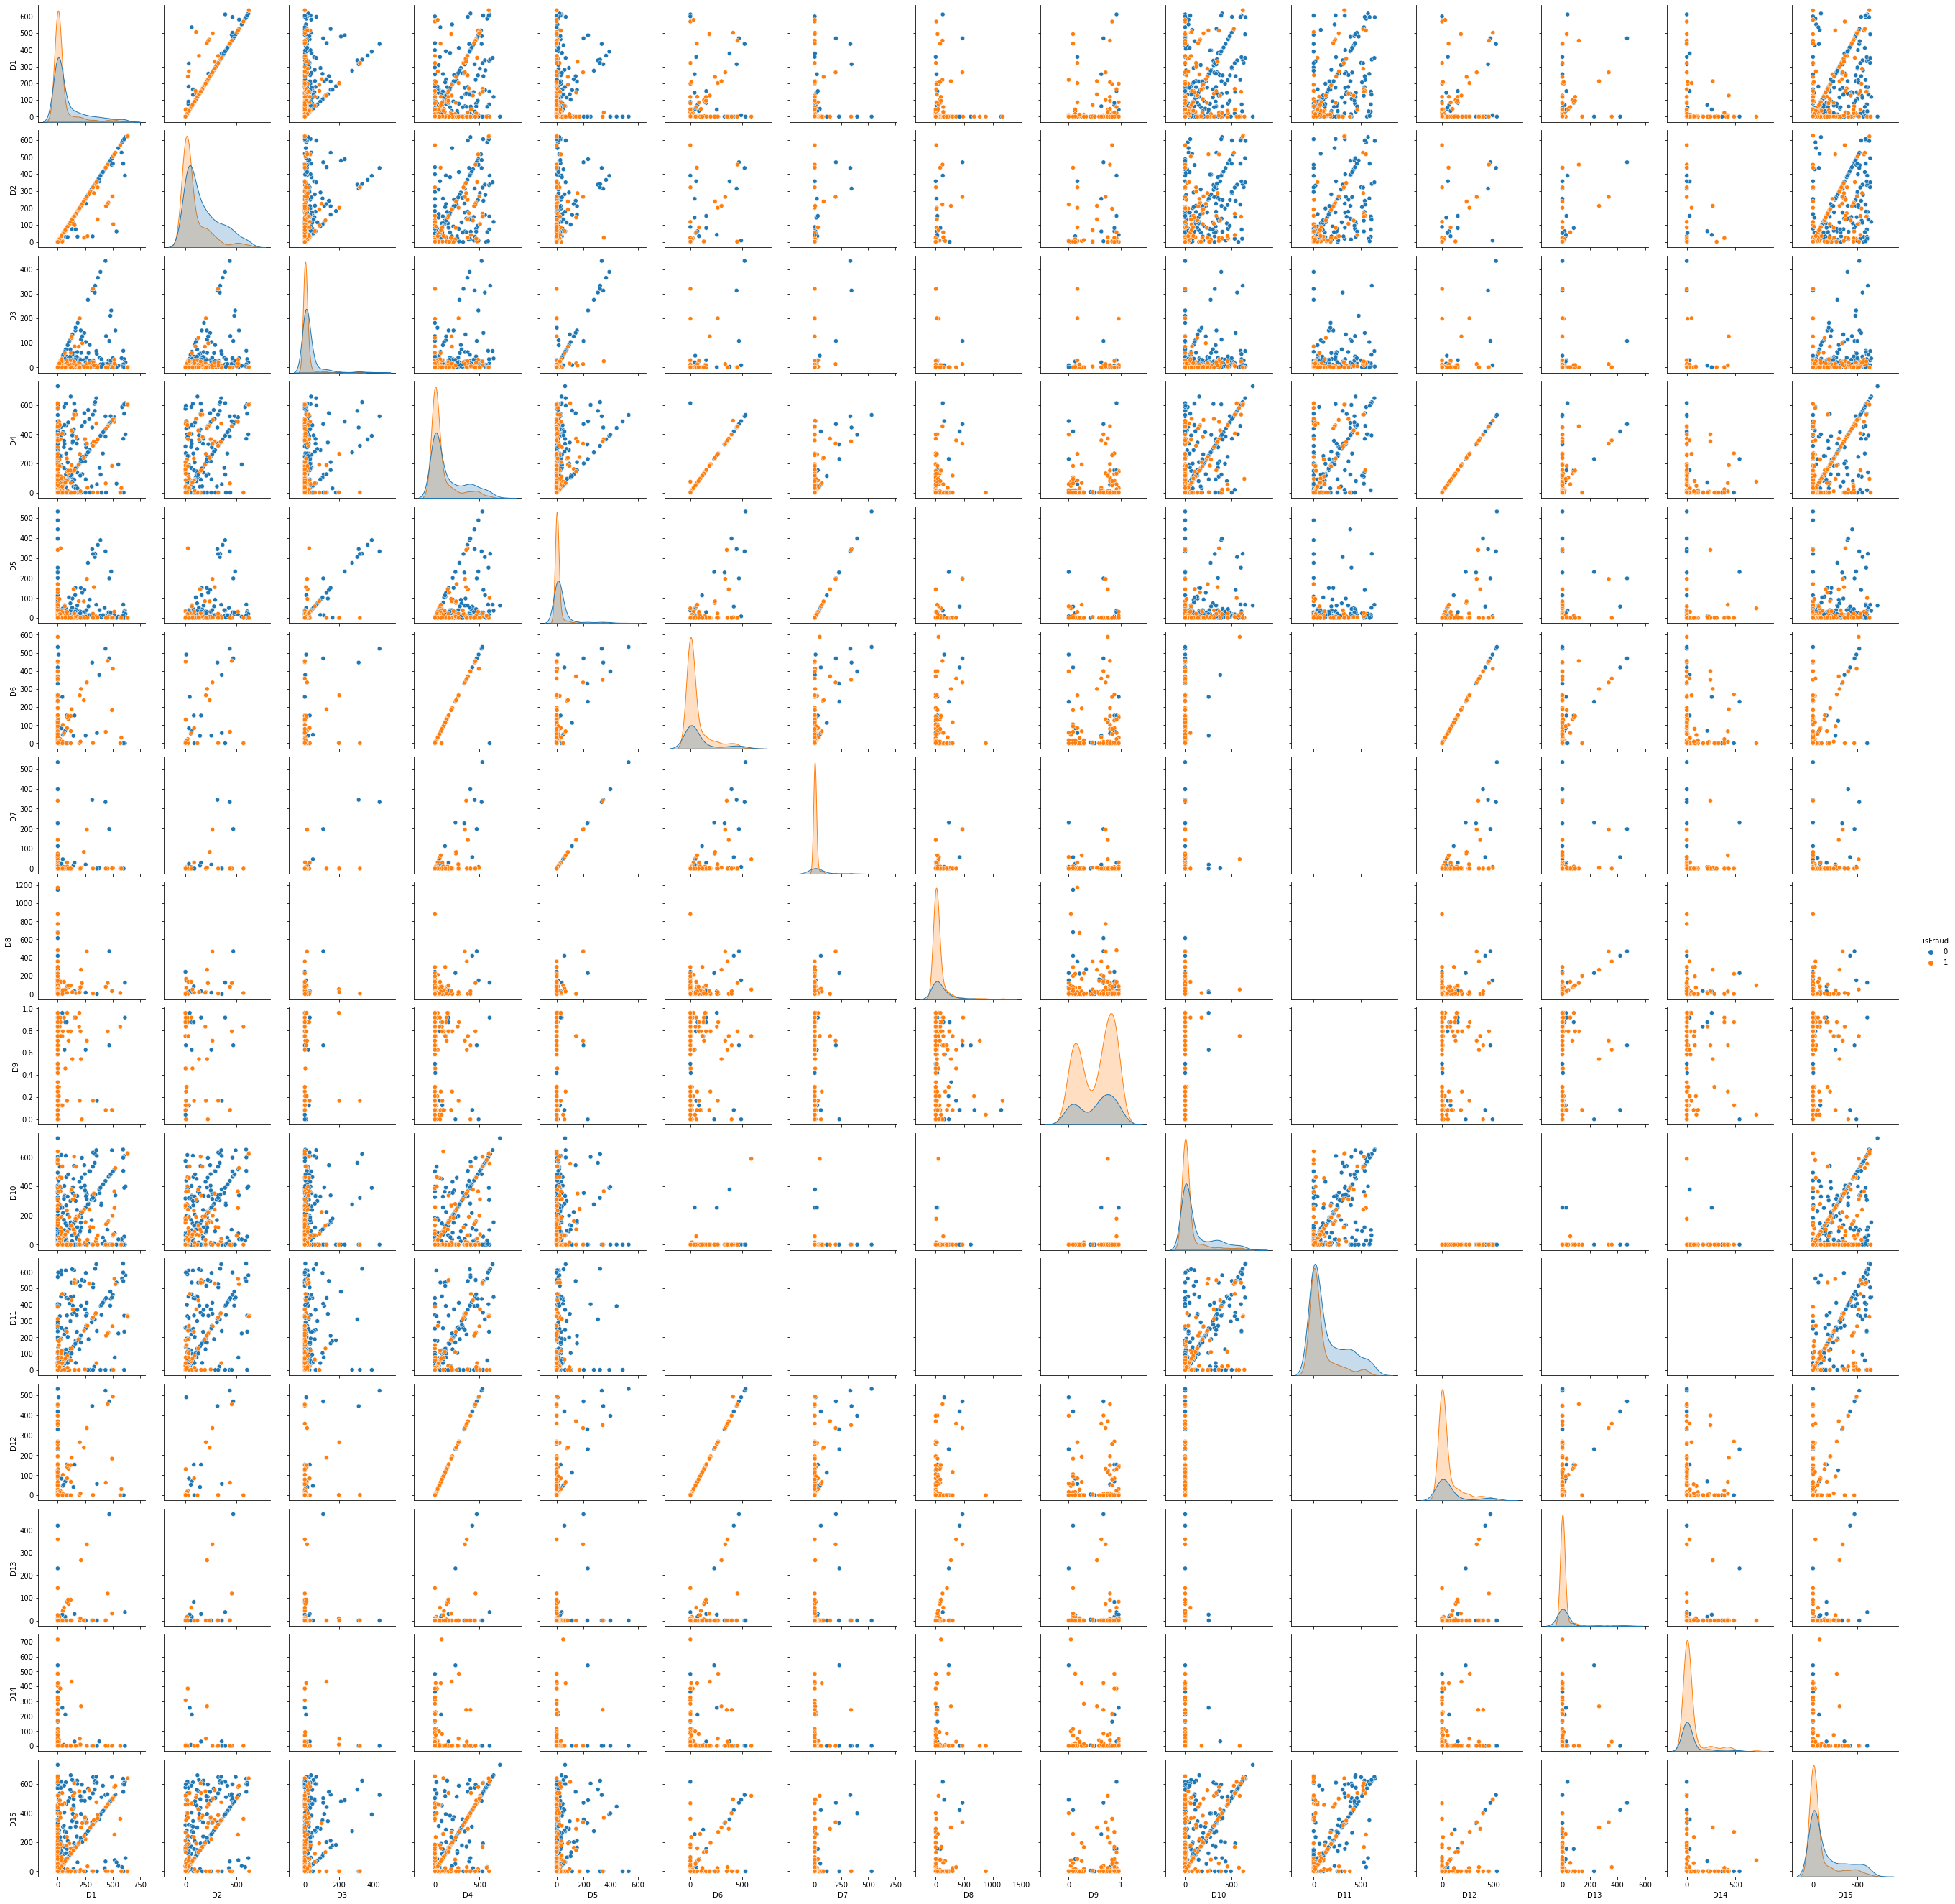

In [ ]:
sns.pairplot(sampled_train, 
             hue='isFraud',
            vars=d_cols)
plt.show()

# M1 - M9

In [ ]:
m_cols = [c for c in train_transaction if c[0] == 'M']
train_transaction[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A partir daqui estamos relacionando M1-M9 com casos de fraude e não fraude:

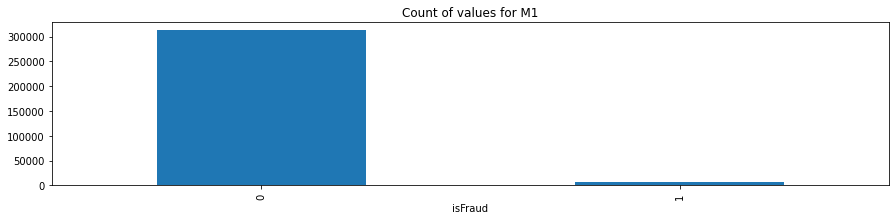

In [ ]:
#D.M.
train_transaction.groupby('isFraud')['M1'] \
    .count() \
    .plot(kind='bar',
          title='Count of values for M1',
          figsize=(15, 3))
plt.show()

In [ ]:
#D.M. 
#Since the M4 colum values are other than T and F, let us see the distinct values in this column
print(train_transaction['M4'].unique())

['M2' 'M0' nan 'M1']


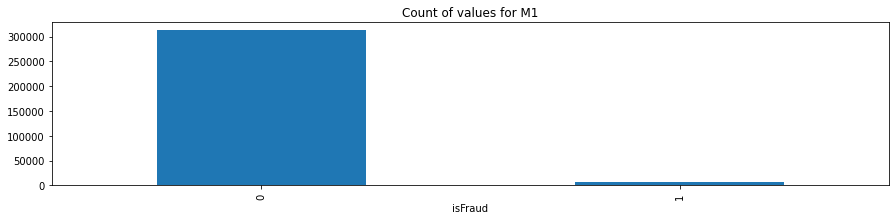

In [ ]:
#D.M.
train_transaction.groupby('isFraud')['M1'] \
    .count() \
    .plot(kind='bar',
          title='Count of values for M1',
          figsize=(15, 3))
plt.show()

É uma revelação interessante. Para todos os valores de M1, quase todas as transações são não fraudulentas. Transações fraudulentas são quase inexistentes.

#V1 - V339

In [ ]:
v_cols = [c for c in train_transaction if c[0] == 'V']
train_transaction[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Podemos observar que as colunas de V tem um número bastante significativo com relação a tabela.

In [ ]:
train_transaction[v_cols].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.072870,1.027704,1.041529,0.463915,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,0.007390,0.240133,0.320890,0.440053,0.475902,0.239385,0.304779,0.186069,0.226339,0.521522,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,8.000000,9.000000,6.000000,6.000000,9.000000,9.000000,8.000000,8.000000,4.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


In [ ]:
train_transaction['v_mean'] = train_transaction[v_cols].mean(axis=1)

In [ ]:
train_transaction['v_mean']

0           3.271605
1           0.313609
2           0.388889
3          66.573964
4         799.648111
             ...    
590535      2.491667
590536      0.388889
590537      0.444444
590538     56.897222
590539     19.263334
Name: v_mean, Length: 590540, dtype: float64

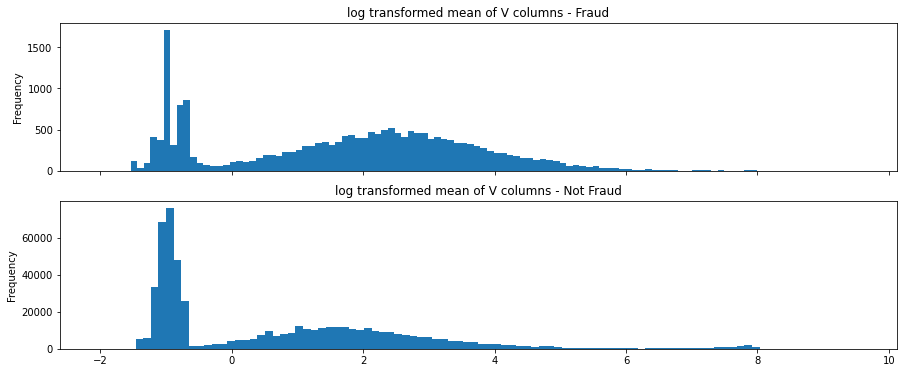

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
train_transaction.loc[train_transaction['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
train_transaction.loc[train_transaction['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          ax=ax2)
plt.show()


Os valores médios V são muito confusos de se olhar em termos de números simples. No entanto, quando você olha para o gráfico log das médias da coluna V, você pode ver que estas são quase uma distribuição normal, exceto os outliers iniciais que, em termos de frequência ou número de casos de fraude/não-fraude, não vêm sob distribuição normal